# PART II: Moving Average

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PolyCollection, LineCollection

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20



def sm_plot(grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    plt.grid(grid, linestyle = ':', color = '0.50')
    # plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
    
    
def sm_plot_mod(ax, grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True,right = True, length = 5,width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8,width = 1, labelsize = 15)

---

In [3]:
df = pd.read_csv('data_reduced.csv', sep = ',')
df

,MESS_DATUM,WATER-LEVEL,DISCHARGE,FILL-LEVEL,VOLUME,RS,RS1,RS2,RS3,RS7,RS14,RSF,FLOOD
0,1990-10-31,4.931,23.0,238.312,5.169,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1990-11-01,13.076,47.0,238.530,5.348,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,1990-11-02,6.078,26.0,238.729,5.512,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,1990-11-03,4.931,23.0,238.875,5.632,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,1990-11-04,5.698,25.0,238.994,5.730,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23282,2023-12-27,0.000,0.0,0.000,0.000,2.8,0.000000,13.805612,17.251582,27.545747,8.409038,4.0,0.0
23283,2023-12-28,0.000,0.0,0.000,0.000,0.3,12.782493,0.592617,1.429676,12.063629,9.029170,4.0,0.0
23284,2023-12-29,0.000,0.0,0.000,0.000,17.6,10.346342,0.000000,6.685611,0.813981,4.013248,4.0,0.0
23285,2023-12-30,0.000,0.0,0.000,0.000,0.1,1.598052,5.983179,19.987744,5.539653,1.975216,4.0,0.0


## ADF Stationarity Test

In [4]:
adf_test = adfuller(df['WATER-LEVEL'])

print('WATER-LEVEL')
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

WATER-LEVEL
ADF Statistic: -10.449052
p-value: 0.000000


In [31]:
n = len(df['WATER-LEVEL'])

# STURGES VALUE
nlags = 50
lags_sturges = int(np.log2(n) + 1)
acf_wl = acf(df['WATER-LEVEL'], nlags = nlags)
acf_dis = acf(df['DISCHARGE'], nlags = nlags)

Confidence interval

In [27]:
def bartlett_confidence_intervals(acf_values, num_samples, confidence_level=0.95):
    z = 1.96  # Para um intervalo de confiança de 95%
    lags = np.arange(len(acf_values))
    # Inicializa a lista de desvios padrão
    standard_errors = np.zeros(len(acf_values))
    
    # Calcula o desvio padrão para cada lag usando a fórmula de Bartlett
    for k in lags:
        if k == 0:
            standard_errors[k] = 0  # ACF no lag 0 é 1, não há desvio padrão associado
        else:
            standard_errors[k] = np.sqrt((1 + 2 * np.sum(acf_values[:k] ** 2)) / num_samples)
    
    # Calcula o intervalo de confiança
    confidence_intervals = z * standard_errors
    
    return confidence_intervals


ci_wl = bartlett_confidence_intervals(acf_wl, n)
ci_dis = bartlett_confidence_intervals(acf_dis, n)

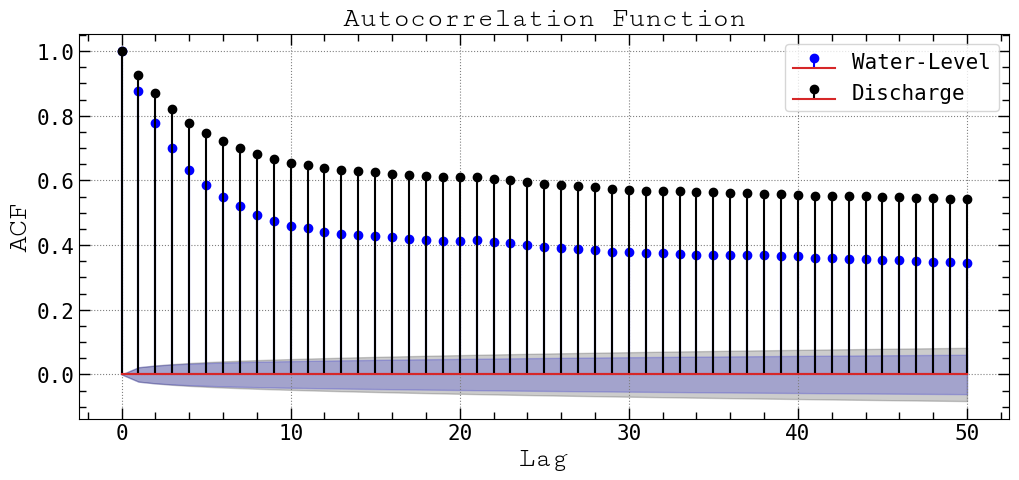

In [28]:
plt.figure(figsize = (12,5))

plt.stem(range(50 + 1), acf_wl, 'b', label = 'Water-Level')
plt.stem(range(50 + 1), acf_dis, 'k', label = 'Discharge')

lags = np.arange(51)
plt.fill_between(lags, ci_wl, -ci_wl, color = 'b', alpha = 0.2)
plt.fill_between(lags, ci_dis, -ci_dis, color = 'k', alpha = 0.2)

plt.title('Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
plt.xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)
plt.ylabel('ACF', fontproperties = cm_font, fontsize = cm_size)

sm_plot()
plt.legend(loc = 'best')

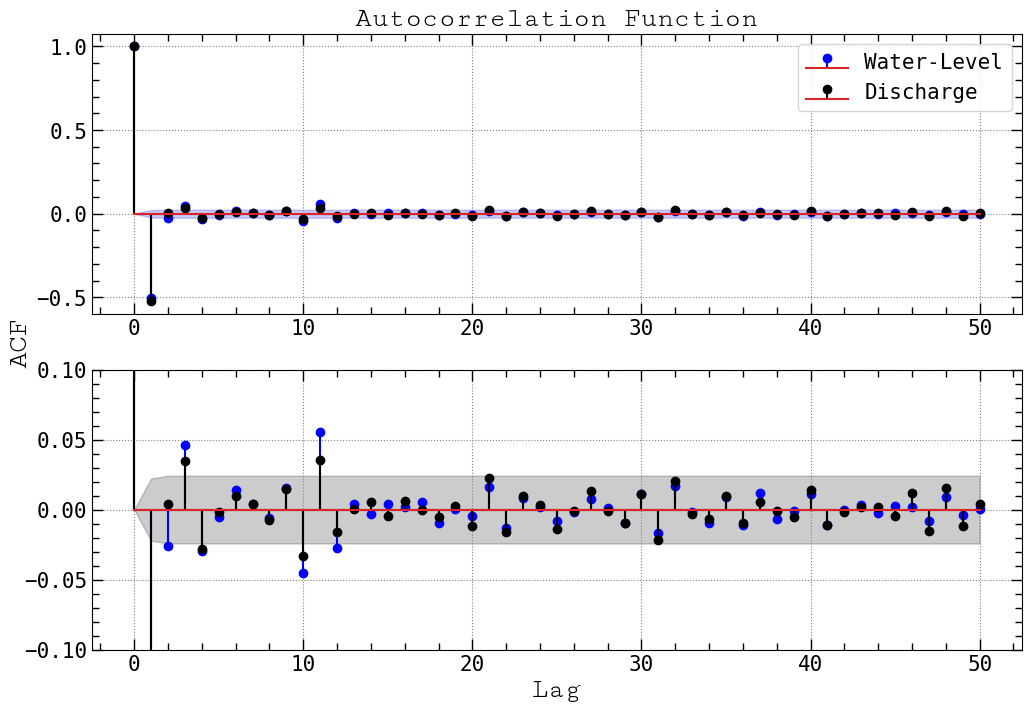

In [55]:
wl_diff = np.diff(df['WATER-LEVEL'], n = 2)
dis_diff = np.diff(df['DISCHARGE'], n = 2)

acf_wl_diff = acf(wl_diff, nlags = nlags)
acf_dis_diff = acf(dis_diff, nlags = nlags)

ci_wl_diff = bartlett_confidence_intervals(acf_wl_diff, n)
ci_dis_diff = bartlett_confidence_intervals(acf_dis_diff, n)




fig = plt.figure(figsize = (12,8))
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

ax0.stem(range(50 + 1), acf_wl_diff, 'b', label = 'Water-Level')
ax0.stem(range(50 + 1), acf_dis_diff, 'k', label = 'Discharge')

ax1.stem(range(50 + 1), acf_wl_diff, 'b', label = 'Water-Level')
ax1.stem(range(50 + 1), acf_dis_diff, 'k', label = 'Discharge')

ax0.fill_between(lags, ci_wl_diff, -ci_wl_diff, color = 'b', alpha = 0.2)
ax1.fill_between(lags, ci_dis_diff, -ci_dis_diff, color = 'k', alpha = 0.2)

ax0.set_title('Autocorrelation Function', fontproperties = cm_font, fontsize = cm_size)
ax1.set_xlabel('Lag', fontproperties = cm_font, fontsize = cm_size)
ax0.set_ylabel('ACF', y = -0.1, fontproperties = cm_font, fontsize = cm_size)

ax1.set_ylim(-0.1,0.1)

sm_plot_mod(ax0)
sm_plot_mod(ax1)
ax0.legend(loc = 'best')

In [72]:
df_diff = pd.DataFrame({'WATER-LEVEL': wl_diff})

train_wl = df_diff[:18_623]
test_wl = df_diff[18_623:]

In [73]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [75]:
df['WATER-LEVEL (pred)'] = pd.Series()
df['WATER-LEVEL (pred'][18_624:] = df['WATER-LEVEL'].iloc[18_624] + pred_df['pred_MA'].cumsum()

NameError: name 'pred_df' is not defined